In [2]:
# Core scverse libraries
import scanpy as sc
import anndata as ad
import skimage
import igraph

# Data retrieval
import pooch

sc.settings.set_figure_params(dpi=50, facecolor="white")

Importing the packages used for this project
Anndata is a file format for matrix like data, Data is in the form n_observations x n_variables. In this case, the observations are the cells measured and the variables are the expression of each gene. Simply, the matrix is cells x genes

sc.settings.set_figure_params(dpi=50, facecolor="white") configures the styling of plots used later on

In [3]:
#Importing example data
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

In [4]:
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
}

adatas = {}
for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs)

c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


                   sample
AAACCCAAGGATGGCT-1   s1d1
AAACCCAAGGCCTAGA-1   s1d1
AAACCCAAGTGAGTGC-1   s1d1
AAACCCACAAGAGGCT-1   s1d1
AAACCCACATCGTGGC-1   s1d1
...                   ...
TTTGTTGAGAGTCTGG-1   s1d3
TTTGTTGCAGACAATA-1   s1d3
TTTGTTGCATGTTACG-1   s1d3
TTTGTTGGTAGTCACT-1   s1d3
TTTGTTGTCGCGCTGA-1   s1d3

[17125 rows x 1 columns]


c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\chpar\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


This section of code places the imported example data into an anndata object
samples dictionary containts the two samples selected for analysis. Data set contains many samples but only 2 were selected for the tutorial

Each sample is looped through, read the data. Data was in 10x genomic format so the specific read function for that format was used 
The variable names are made to be unique. This just appends integers to repeaded strings in order to make each one unique
Then this adata object is put in the adata dictionary with it's sample id as the key

Then the two adata objects are concatonated to put all of the data in a single adata object
Finally, indexs are made unique again by appending integers to repeated elements



## Quality Control

In [4]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [5]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

calculate_qc_metrics() calculates the quality control metrics 
Metrics are calculated for mitochondrial, ribosomal, and hemoglobin genes

These metrics tell us the total number of genes expressed, the total gene counts per cell, and the percentage counts of mitochondrial genes which can be used to validate the quality of the data set

These metrics are also necessary for filtering the data

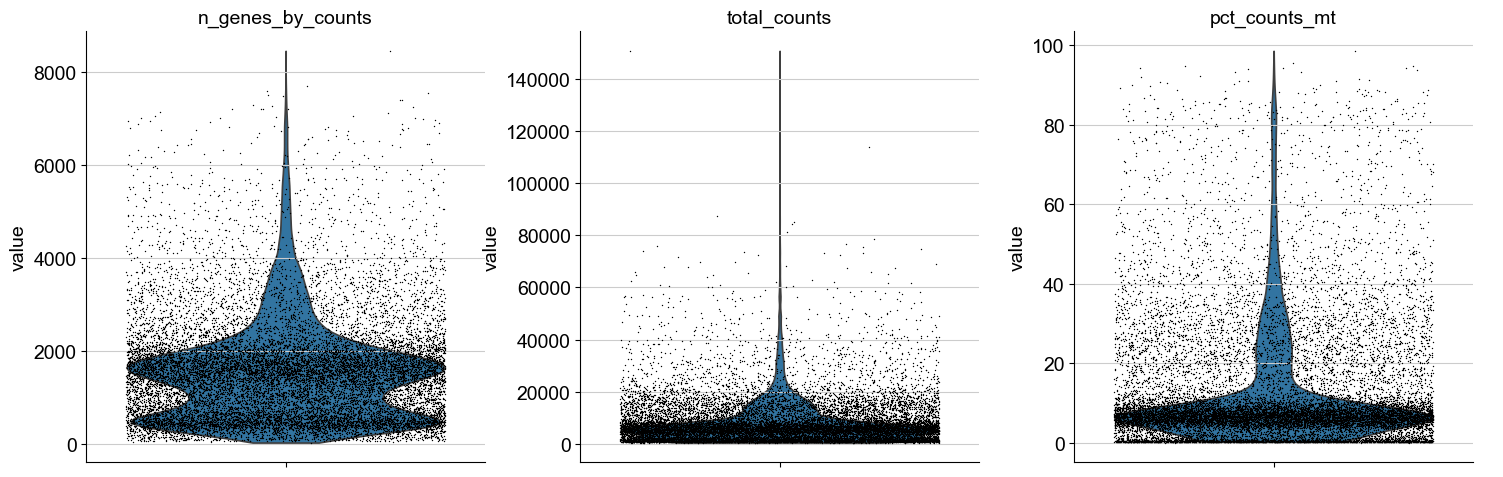

In [6]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

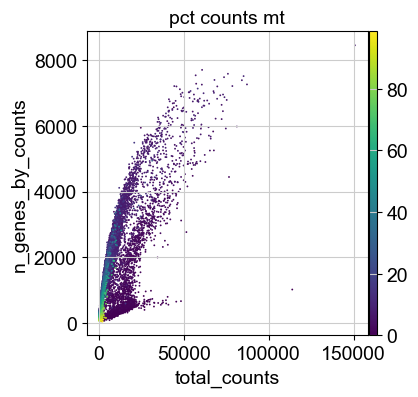

In [7]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [8]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

Using the qc data generated above we can now filter some cells. This code removes cells with less than 100 genes and removes genes that are expressed in less than 3 cells

Qc should be done per sample on data sets with many batches because qc thresholds can differ between them 

## Normalization

In [9]:
sc.pp.scrublet(adata, batch_key="sample")

Doublets then must be identified and removed to avoid missclassification and distortions later on
scrublet identifies doublets and adds a doublet score (value) and predicted doublet (boolean) for each observed cell

Doublets can be filtered now or later using either the doublet score or predicted doublet metrics


In [10]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [11]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

Data is normalized to accurately compare expression between cells
This normalization is done by a count depth scaling followed by a log plus one transformation
The count depth is the average number of reads covering a reference base

Count depths scaling normalizes the data to a specific size such as to the median count depth in the data set, or a given integer
The size is set by the target_sum property. In this case we are normalizing to the median count depth of the data set


## Feature Selection

In [12]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")

The next step is feature selection, this is done in order to reduce the dimensionality to the most informative genes
Genes with the highest variability are the most informative so the top 2000 most variable genes were selected

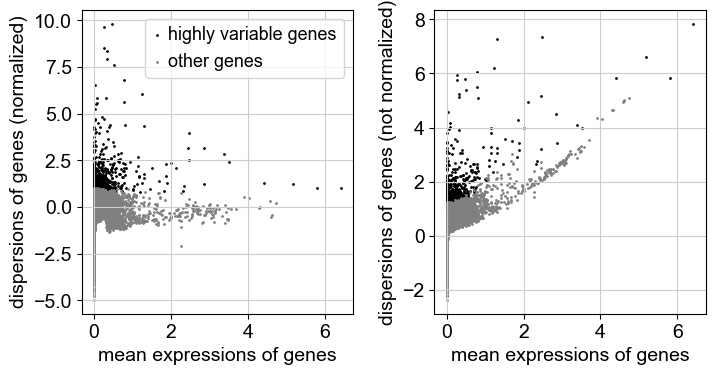

In [13]:
sc.pl.highly_variable_genes(adata)

## Dimensionality Reduction

In [14]:
sc.tl.pca(adata)

A PCA(Principal Component Analysis) reveals the main axes of variation and helps denoise the data

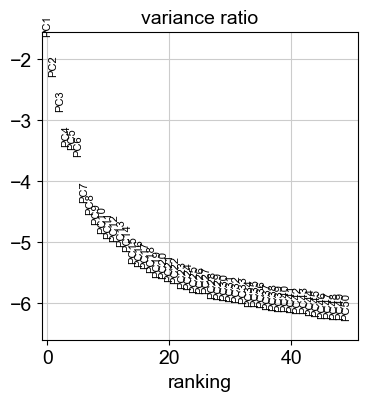

In [15]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

Graphing tells us how many PCs to consider. In general overestimating is not detrimental though

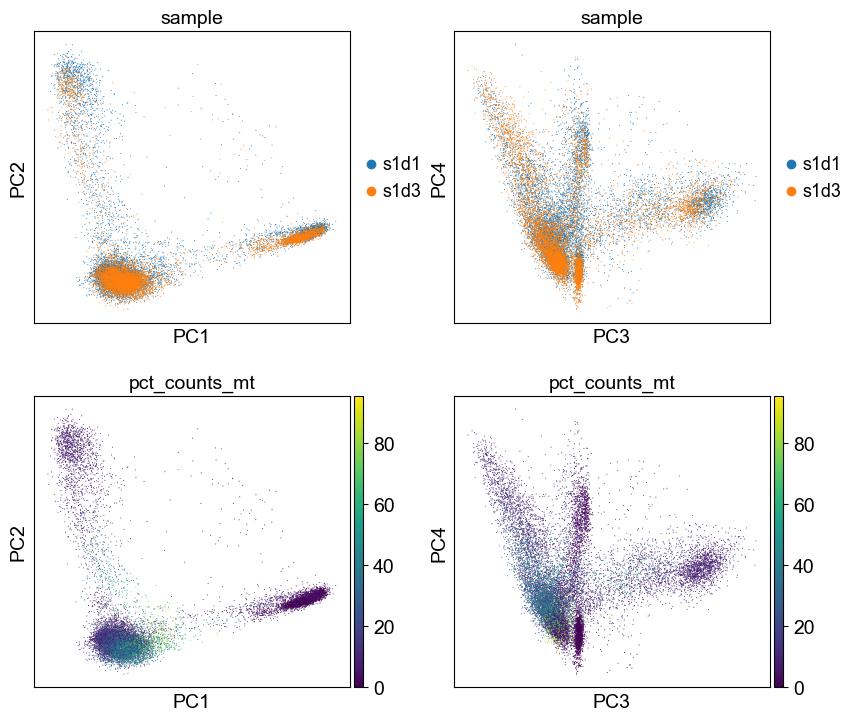

In [16]:
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

Plotting the PCs can identify if there are any batch or qc metrics causing significant variance
Above we can see that there is not significant variance between the two sample sets (s1d1 and s1d3) so we are all good

## Nearest Neighbor Graph Construction

In [17]:
sc.pp.neighbors(adata)

In [18]:
sc.tl.umap(adata)

Fistly, a neighborhood graph using the PCA representation is computed. It places similar cells in groups
Then the graph is put into 2 dimensions for proper visualization  which we then plot

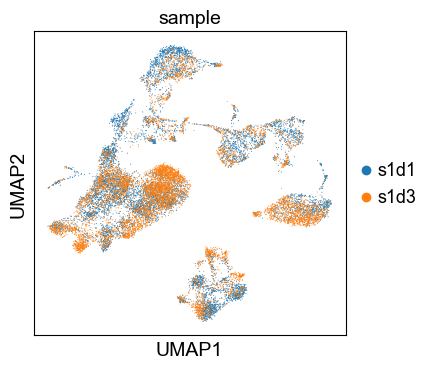

In [19]:
sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

## Clustering

In [20]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata) 

C:\Users\chpar\AppData\Local\Temp\ipykernel_23972\984596335.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


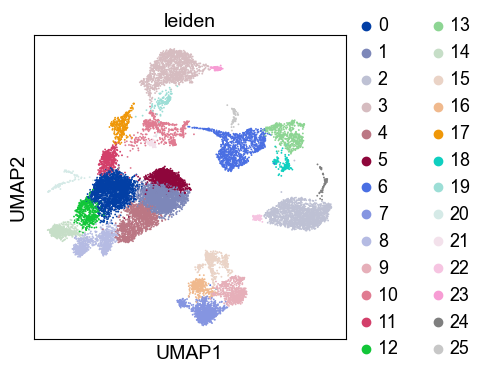

In [21]:
sc.pl.umap(adata, color=["leiden"])

## Re-asses QC and Filtering

Plot different qc metrics using UMAP to verify the filtering strategy

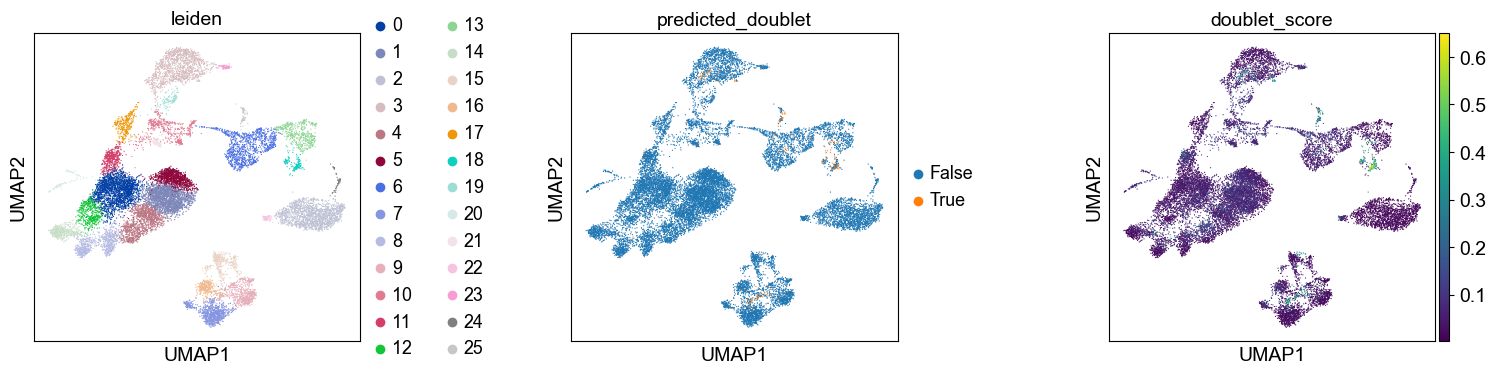

In [22]:
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

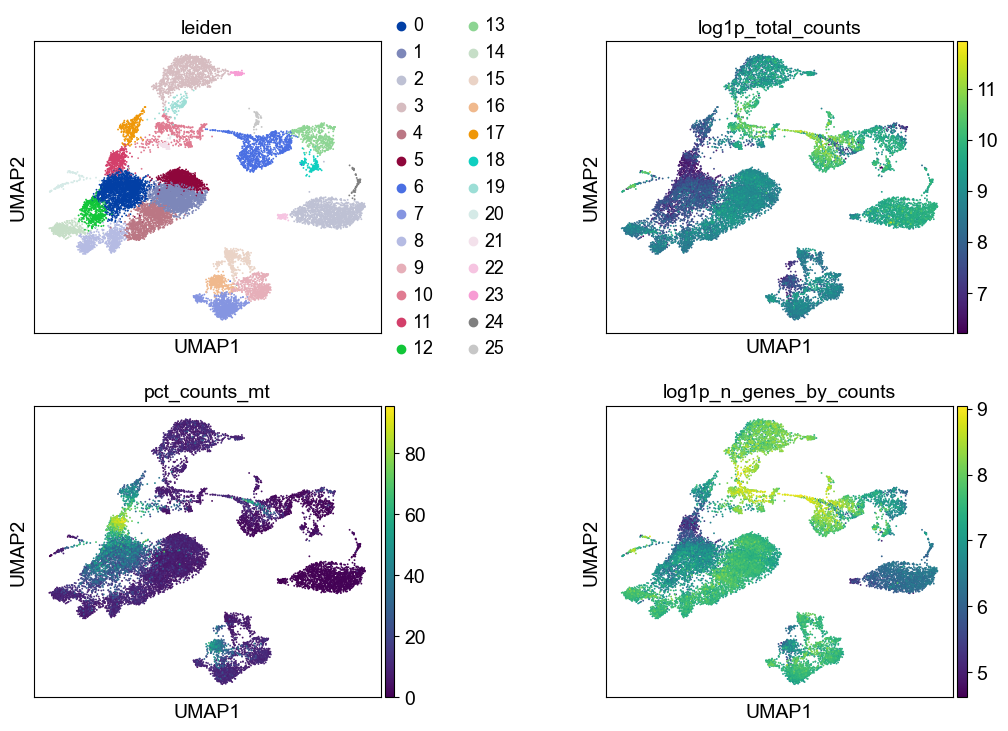

In [23]:
sc.pl.umap(
    adata,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

## Manual Cell-type Annotation

Annotation is typically done using genes that are exclusively expressed by a single cell type. Using this we can distinguish different cell types
Typically use marker genes to generate clustering solutions. Here we used the leiden clustering algorithm.

"The number of clusters define is largely arbitrary and so is the resolution parameter used to control for it" This is why we repeat this step with 3 different resolution options in order to compare the results

In [24]:
for res in [0.02, 0.5, 2.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res
    )

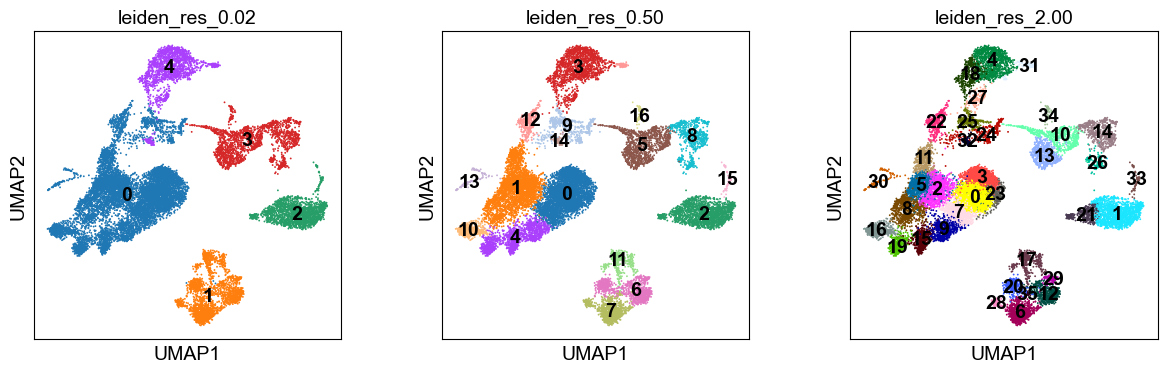

In [25]:
sc.pl.umap(
    adata,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_2.00"],
    legend_loc="on data",
)

Highest resolution of data is over-clustered while thhe lower resolution is grouping cells that belong to distinct identities

## Marker Gene Set

In [26]:
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    # Note: DMXL2 should be negative
    "cDC2": ["CST3", "COTL1", "LYZ", "DMXL2", "CLEC10A", "FCER1A"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    # Note HBM and GYPA are negative markers
    "Proerythroblast": ["CDK6", "SYNGR1", "HBM", "GYPA"],
    "NK": ["GNLY", "NKG7", "CD247", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    # Note IGHD and IGHM are negative markers
    "B cells": [
        "MS4A1",
        "ITGB1",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
    ],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    # Note PAX5 is a negative marker
    "Plasmablast": ["XBP1", "PRDM1", "PAX5"],
    "CD4+ T": ["CD4", "IL7R", "TRBC2"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
}

This is a defined set of marker genes. These were given and adapter to fit this data set
When using a defined list of marker gnees it is important to remove the marker genes that are not present in our dataset

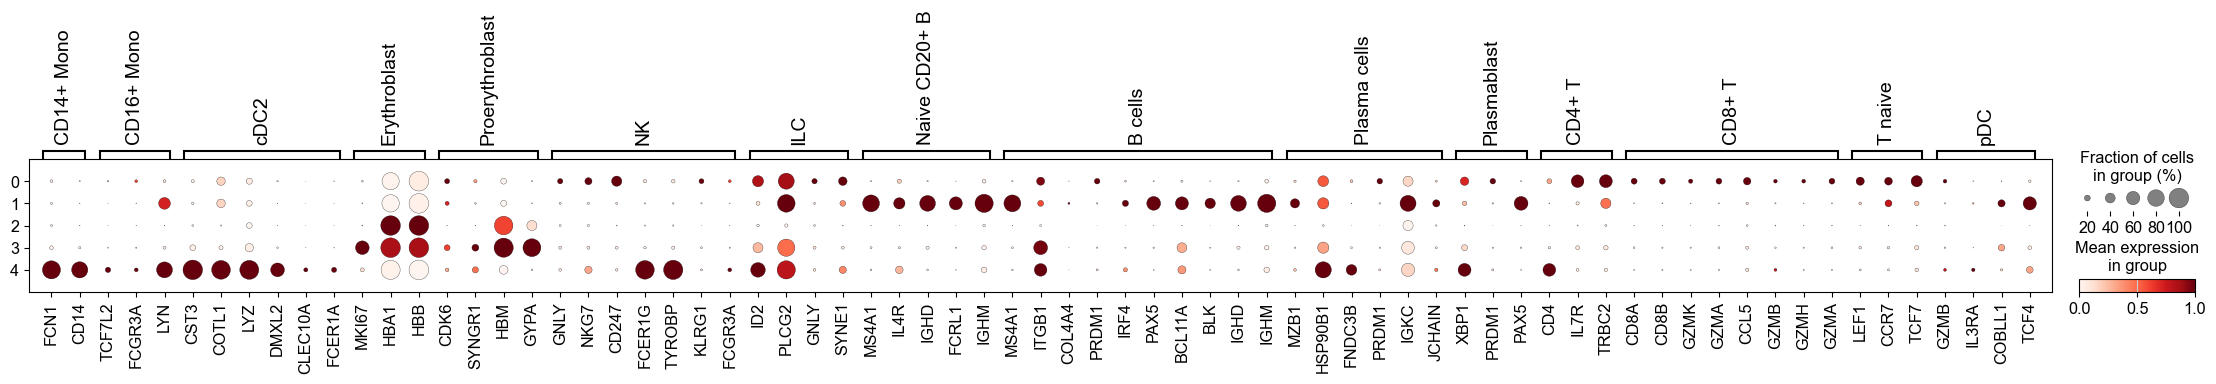

In [27]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.02", standard_scale="var")

In [28]:
adata.obs["cell_type_lvl1"] = adata.obs["leiden_res_0.02"].map(
    {
        "0": "Lymphocytes",
        "1": "Monocytes",
        "2": "Erythroid",
        "3": "B Cells",
    }
)

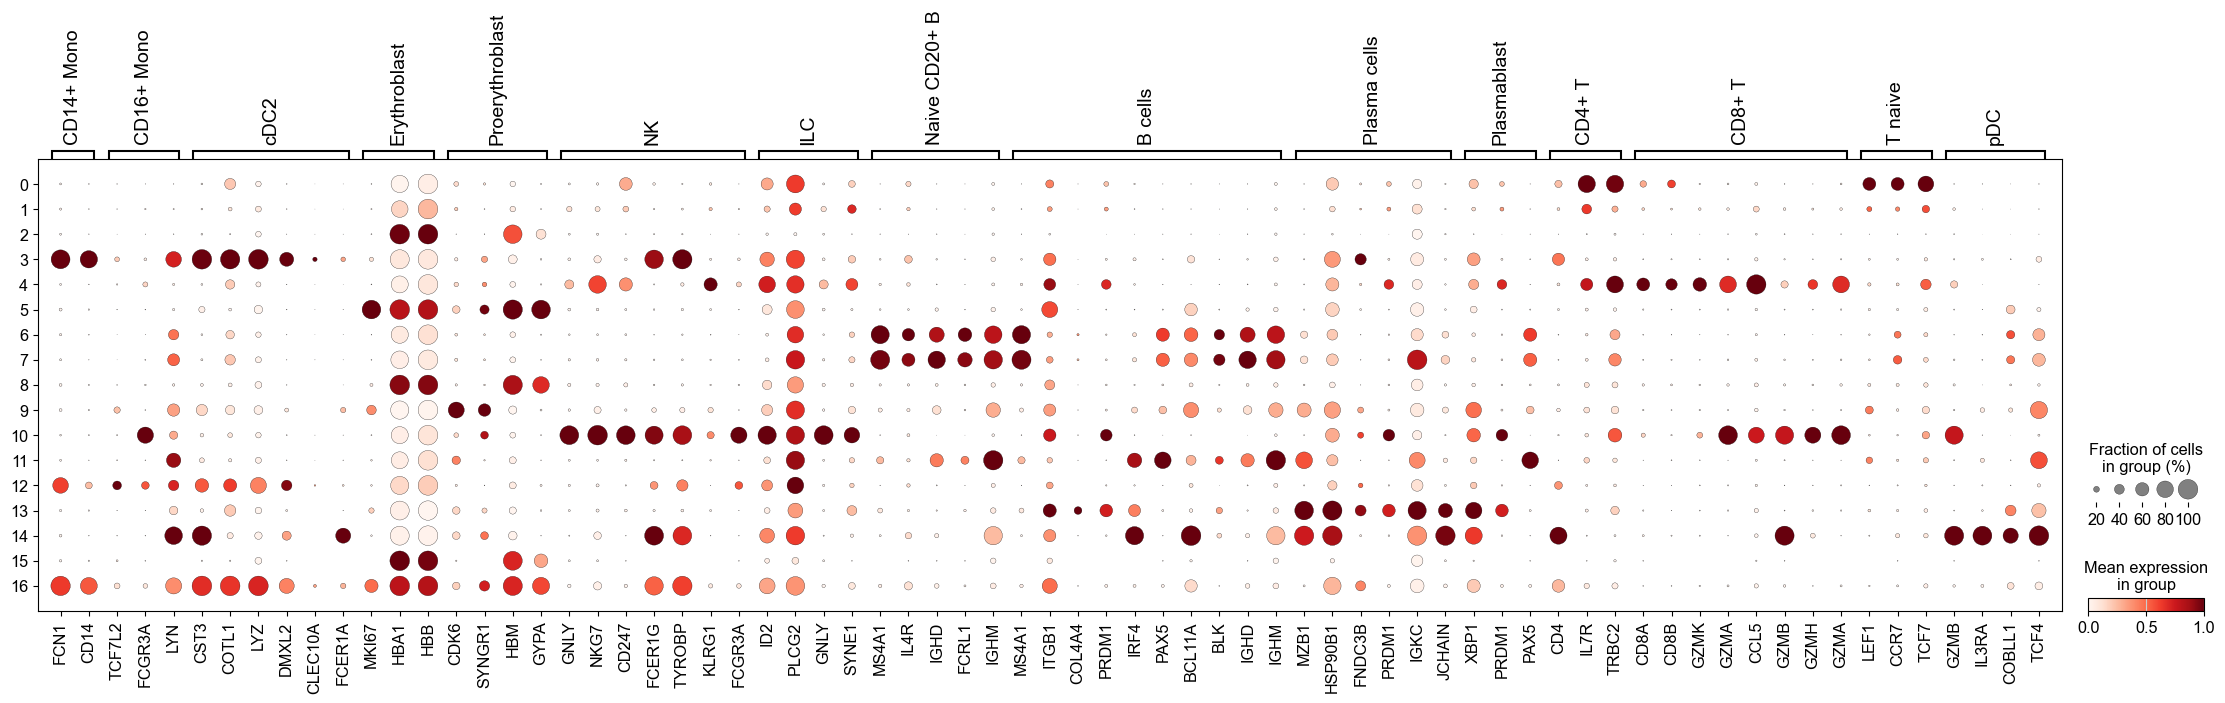

In [29]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.50", standard_scale="var")

## Differentially-expressed Genes as Markers

We can caluculate marker genes per cluster and then see if we can link the markers to known biology such as cell types or states

In [30]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden_res_0.50", method="wilcoxon")

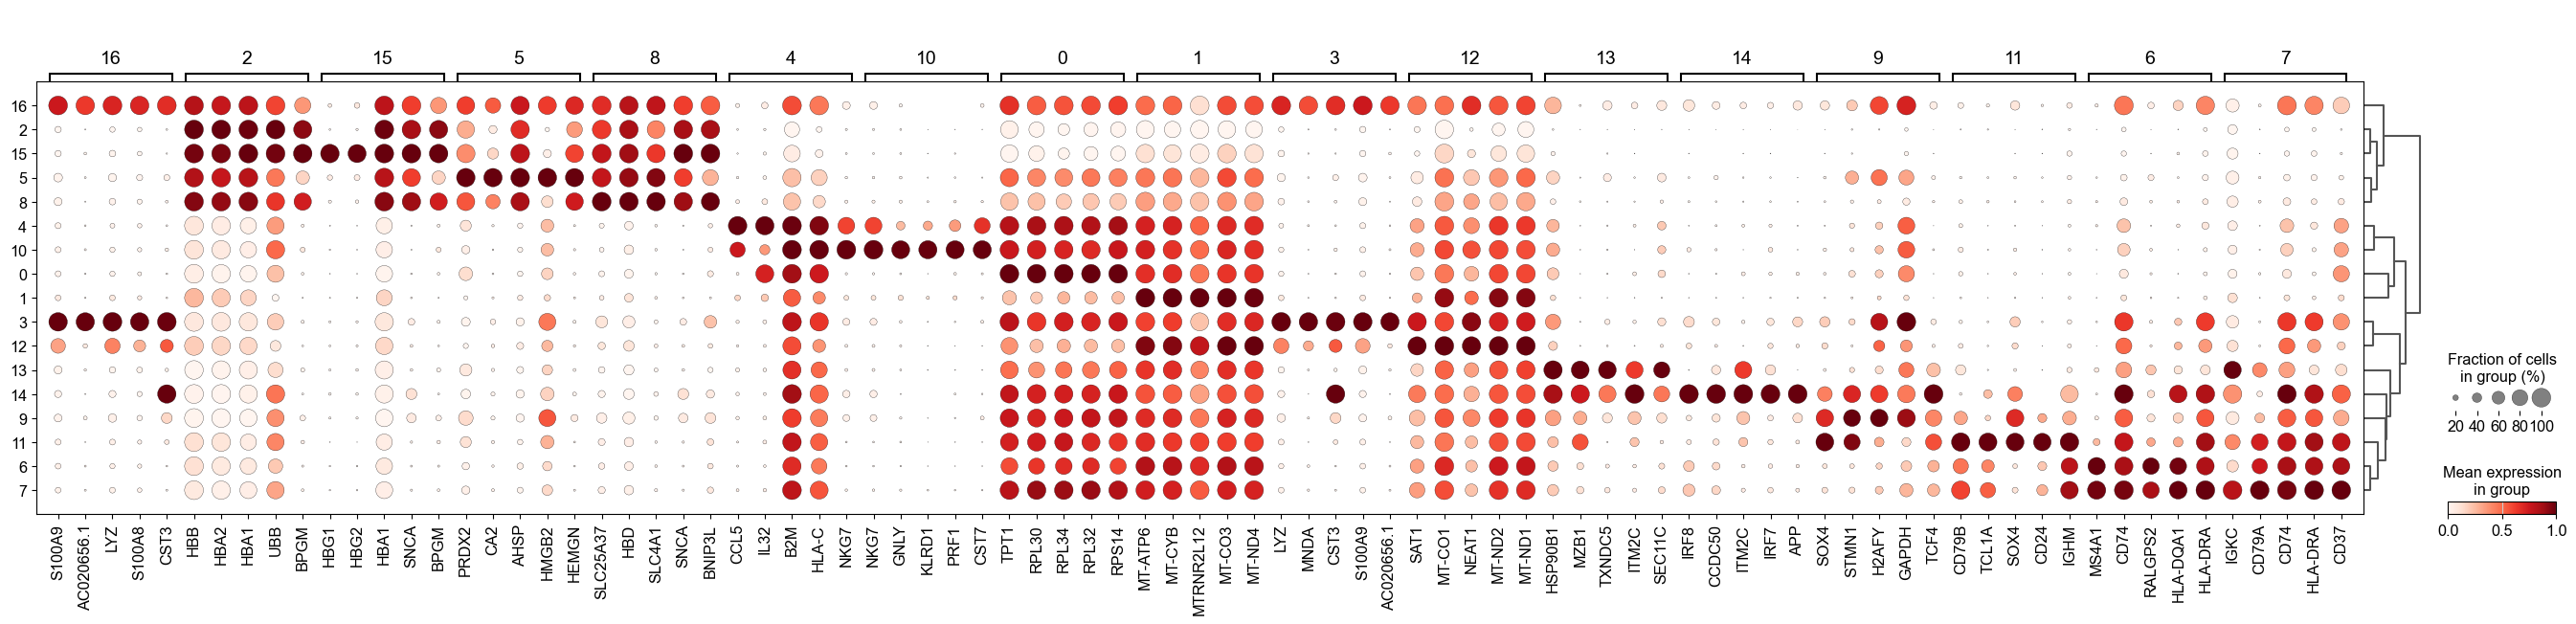

In [31]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res_0.50", standard_scale="var", n_genes=5
)

Using these genes we can figure out what cell types we have

Example: Cluster 10 us expressing NKG7 and GNLY, suggesting that these are NK cells

The differentially expressed genes can be expressed in an easy to read format using the line of code below

This process can be repeated for each group in order to identify the cell type of each group

In [33]:
sc.get.rank_genes_groups_df(adata, group="10").head(5)

,names,scores,logfoldchanges,pvals,pvals_adj
0,NKG7,35.501884,6.550209,4.597223e-276,1.076991e-271
1,GNLY,33.813511,7.376138,1.248497e-250,1.462426e-246
2,KLRD1,33.772213,5.831674,5.046906e-250,3.941129e-246
3,PRF1,33.072800,5.439067,7.315428e-240,4.284463e-236
4,CST7,33.056469,5.242485,1.255856e-239,5.884188e-236


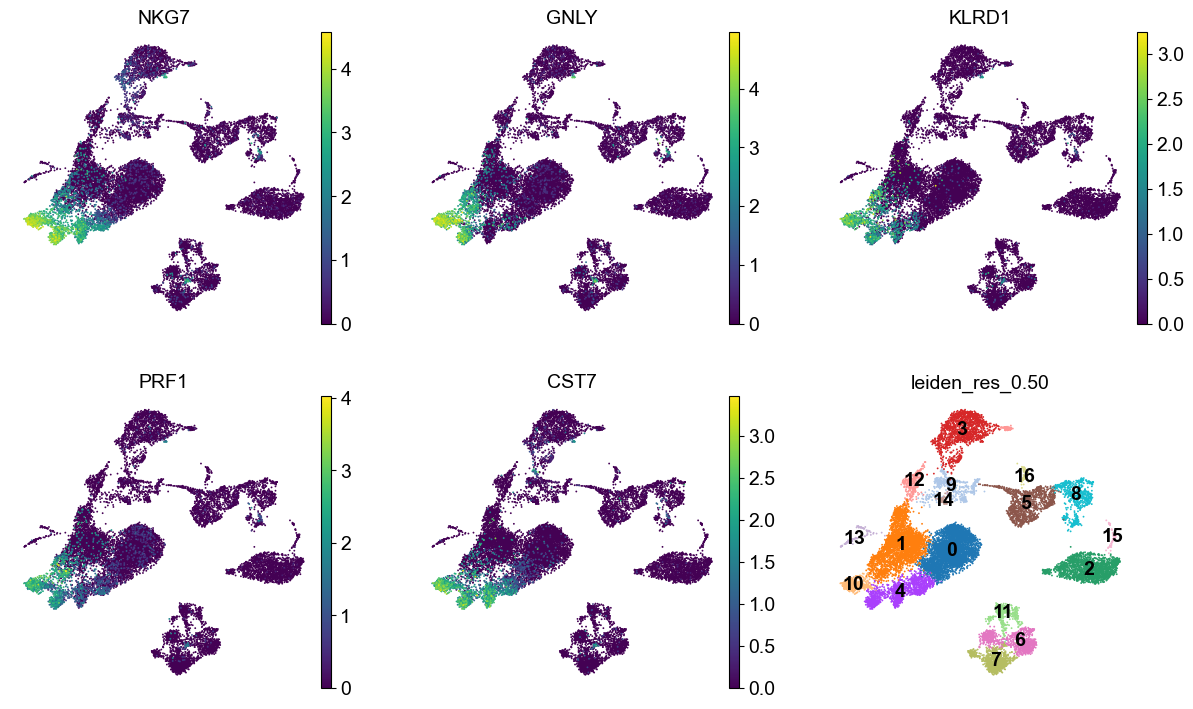

In [35]:
dc_cluster_genes = sc.get.rank_genes_groups_df(adata, group="10").head(5)["names"]
sc.pl.umap(
    adata,
    color=[*dc_cluster_genes, "leiden_res_0.50"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)

These plots show the differentially expressed genes in umap form 

Tutorial Link: https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html#